In [1]:
import os
import json
import warnings
from utils import info, split_train_and_test_period, evaluation, split_x_and_y_log, parsing_output

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

from sacred import Experiment
from sacred.observers import FileStorageObserver

from xgboost import XGBRegressor


warnings.filterwarnings('ignore')

In [2]:
base_query = """
WITH base_data AS (
    # nyc_taxi 테이블의 좌표가 gis에 있는 geo값이 포함되어 있는 row만 출력하여 zip_code 정보를 얻어내는 테이블 : 12322300
    SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
    FROM (
        SELECT *
        FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
        WHERE 
            EXTRACT(MONTH from pickup_datetime) = 1
            and pickup_latitude BETWEEN -90 AND 90
        ) AS nyc_taxi
    JOIN (
        SELECT zip_code, state_code, state_name, city, county, zip_code_geom
        FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
        WHERE state_code='NY'
        ) AS gis 
    ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)
, distinct_datetime AS (
    # base_data 에서 hour 이후 값을 제거하고 유니크한 시간단위의 pickup data의 정보를 얻어내는 테이블 : 744
    # Datetime만 distinct해서 가져옴(비어있지 않을것이라 가정)
    SELECT distinct DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour
    FROM base_data
)
, distinct_zip_code AS (
    # base_data 에서 zip_code의 정보를 얻어내는 테이블 : 374
    # zip_code만 distinct해서 가져옴(이외의 zip_code는 나오지 않을것이라 가정)
    SELECT distinct zip_code
    FROM base_data
)
, zip_code_datetime_join AS (
    # zip_code, pickup_hour의 정보를 가진 두 테이블을 join하여 여러 단위의 날짜 데이터를 얻는 테이블 : 278256
    SELECT
        *,
        EXTRACT(MONTH FROM pickup_hour) AS month,
        EXTRACT(DAY FROM pickup_hour) AS day,
        CAST(FORMAT_DATETIME('%u', pickup_hour) AS INT64) -1 AS weekday,
        EXTRACT(HOUR FROM pickup_hour) AS hour,
        CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_hour) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend
    FROM distinct_zip_code  
    CROSS JOIN distinct_datetime
)
, agg_data AS (
    # base_data 에서 zip_code별 시간 단위의 픽업 수에 대한 정보 테이블 : 87020
    SELECT 
        zip_code,
        DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
        COUNT(*) AS cnt
    FROM base_data 
    GROUP BY zip_code, pickup_hour
)
, join_output AS (
    # zip_code별 여러 시간 단위에 대한 수요값 테이블 : 278256
    # zip_code, datetime 데이터에 수요값을 붙이고 없다면 0처리
    SELECT 
        zip_code_datetime.*, 
        IFNULL(agg_data.cnt, 0) AS cnt
    FROM zip_code_datetime_join AS zip_code_datetime
    LEFT JOIN agg_data
    ON zip_code_datetime.zip_code = agg_data.zip_code and zip_code_datetime.pickup_hour = agg_data.pickup_hour
)

SELECT
    *,
    LAG(cnt, 1) OVER(PARTITION BY zip_code ORDER BY pickup_hour) AS lag_1h_cnt,
    LAG(cnt, 24) OVER(PARTITION BY zip_code ORDER BY pickup_hour) AS lag_1d_cnt,
    LAG(cnt, 168) OVER(PARTITION BY zip_code ORDER BY pickup_hour) AS lag_7d_cnt,
    ROUND(AVG(cnt) OVER(PARTITION BY zip_code ORDER BY pickup_hour ROWS BETWEEN 168 PRECEDING AND 1 PRECEDING), 2) AS avg_7d_cnt,
    CAST(STDDEV(cnt) OVER(PARTITION BY zip_code ORDER BY pickup_hour ROWS BETWEEN 168 PRECEDING AND 1 PRECEDING) AS INT64) AS std_7d_cnt,
FROM join_output
order by zip_code, pickup_hour
"""

In [3]:
base_df = pd.read_gbq(query=base_query, dialect='standard', project_id=info['project'])

base_df.tail(2)

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,lag_1h_cnt,lag_1d_cnt,lag_7d_cnt,avg_7d_cnt,std_7d_cnt
278254,14801,2015-01-31 22:00:00,1,31,5,22,1,0,0.0,0.0,0.0,0.01,0.0
278255,14801,2015-01-31 23:00:00,1,31,5,23,1,0,0.0,0.0,0.0,0.01,0.0


In [4]:
le = LabelEncoder()

base_df['zip_code_le'] = le.fit_transform(base_df['zip_code'])

In [5]:
# 0인 값이 존재하기에 log1p를 사용하여 -inf값이 존재하지 않게 log scaling
base_df['log_cnt'] = np.log1p(base_df['cnt'])

train_df, test_df = split_train_and_test_period(base_df, 7)

# Null값에 대해 각 행 기준 다음 행의 값을 채우고, 다음 행이 없다면 0값을 채움
train_df = train_df.fillna(method='backfill')
test_df = test_df.fillna(method='backfill')

x_train, x_test, y_train_log, y_test_raw, y_test_log = split_x_and_y_log(train_df, test_df, y='log_cnt')

In [6]:
print(len(x_train), len(x_test))
x_train.head(2)

206448 71808


,month,day,weekday,hour,is_weekend,lag_1h_cnt,lag_1d_cnt,lag_7d_cnt,avg_7d_cnt,std_7d_cnt,zip_code_le
0,1,1,3,0,0,1221.0,1221.0,1221.0,1221.0,49.0,0
1,1,1,3,1,0,1221.0,1221.0,1221.0,1221.0,49.0,0


In [7]:
results = []
for i in range(1, 6):
    results.append(parsing_output(i))
    
pd.concat(results).sort_values('mse')

,model_name,experiment_num,config,mae,mape,mse
score,XGBRegressor,2,"[{""booster"": ""gbtree"", ""colsample_bytree"": 1.0...",34.77,157.25,11397.45
score,LGBMRegressor,4,"[{""boosting_type"": ""gbdt"", ""colsample_bytree"":...",36.74,155.95,12422.04
score,XGBRegressor,1,"[{""booster"": ""gbtree"", ""colsample_bytree"": 1.0...",38.67,252.00,12708.98
score,LGBMRegressor,3,"[{""boosting_type"": ""goss"", ""colsample_bytree"":...",40.94,285.97,13411.79
score,RandomForestRegressor,5,"[{""bootstrap"": ""True"", ""max_depth"": 11, ""max_f...",44.32,235.08,15981.15


In [8]:
best_params = json.loads(parsing_output(2)['config']['score'])[0]
best_params

{'booster': 'gbtree',
 'colsample_bytree': 1.0,
 'learning_rate': 0.05,
 'max_depth': 11,
 'min_child_weight': 1.0,
 'n_estimators': 1000,
 'subsample': 0.5}

In [9]:
%%time
best_model = XGBRegressor(**best_params, n_jobs=-1)
best_model.fit(x_train, y_train_log)

CPU times: user 3min 50s, sys: 856 ms, total: 3min 51s
Wall time: 3min 51s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=11,
             min_child_weight=1.0, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [10]:
y_pred = best_model.predict(x_test)
y_pred_reverse = np.expm1(y_pred)

In [11]:
score = evaluation(y_test_raw, y_pred_reverse)
score

,mape,mae,mse
score,inf,6.295451,919.943851


---

---

- GradientExplainer 와 TreeExplainer 비교분석 찾기

In [12]:
import shap

In [13]:
%%time
explainer = shap.TreeExplainer(best_model)

shap_values = explainer.shap_values(x_test)

CPU times: user 2h 30min 27s, sys: 16.2 s, total: 2h 30min 44s
Wall time: 2h 30min 53s


In [14]:
import pickle

with open('dataset/shap_values.pkl', 'wb') as f:
    pickle.dump(shap_values, f)

In [16]:
shap.initjs() # 자바스크립트 초기화 (그래프 초기화)

# 첫번째 데이터와 첫번째 shap value를 시각화
shap.force_plot(explainer.expected_value, shap_values[0, :], x_test.iloc[0, :])

In [17]:
shap.initjs()
# 두번째 데이터와 두번째 shap value를 시각화
shap.force_plot(explainer.expected_value, shap_values[1, :], x_test.iloc[1, :])

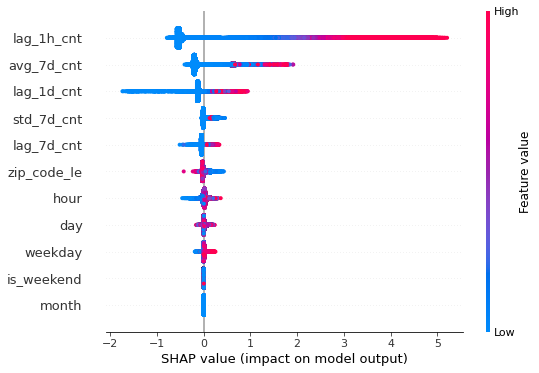

In [18]:
shap.summary_plot(shap_values, x_test)

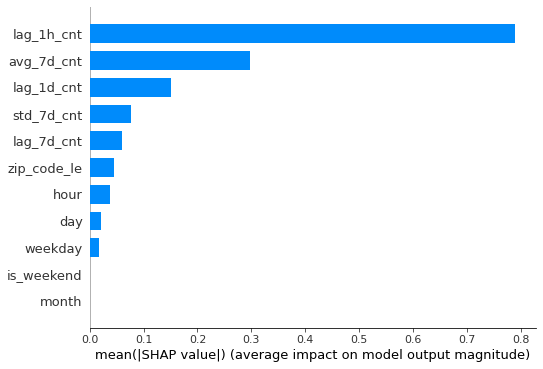

In [19]:
shap.summary_plot(shap_values, x_test, plot_type='bar')

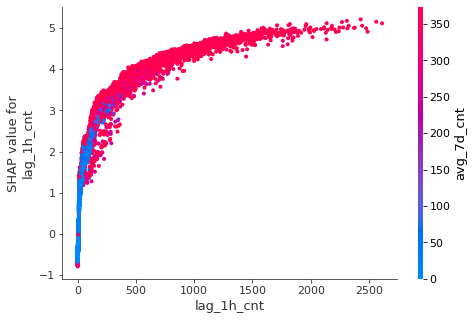

In [20]:
shap.dependence_plot('lag_1h_cnt', shap_values, x_test)

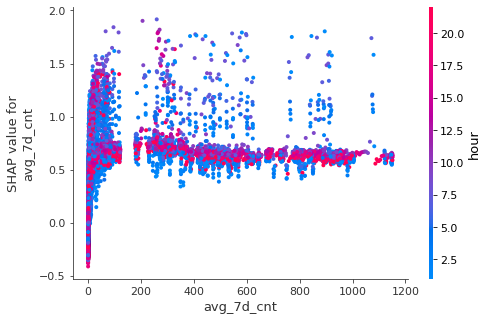

In [21]:
shap.dependence_plot('avg_7d_cnt', shap_values, x_test)

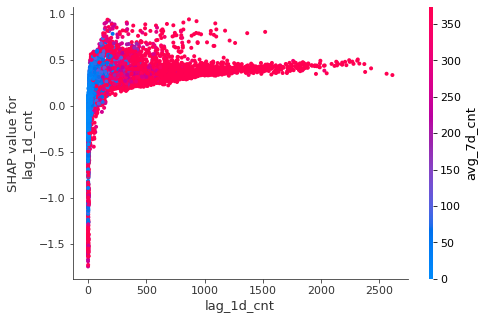

In [22]:
shap.dependence_plot('lag_1d_cnt', shap_values, x_test)

---

---

### Data 복구

In [14]:
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

In [12]:
test_df['y_true'] = y_test_raw
test_df['y_pred'] = y_pred_reverse

test_df['year'] = 2015
test_df['datetime'] = pd.to_datetime(test_df[['year', 'month', 'day', 'hour']])

test_df['zip_code'] = le.inverse_transform(test_df['zip_code_le'])

test_df.tail(2)

,month,day,weekday,hour,is_weekend,lag_1h_cnt,lag_1d_cnt,lag_7d_cnt,avg_7d_cnt,std_7d_cnt,zip_code_le,y_true,y_pred,year,datetime,zip_code
278254,1,31,5,22,1,0.0,0.0,0.0,0.01,0.0,373,0,0.002021,2015,2015-01-31 22:00:00,14801
278255,1,31,5,23,1,0.0,0.0,0.0,0.01,0.0,373,0,-0.003183,2015,2015-01-31 23:00:00,14801


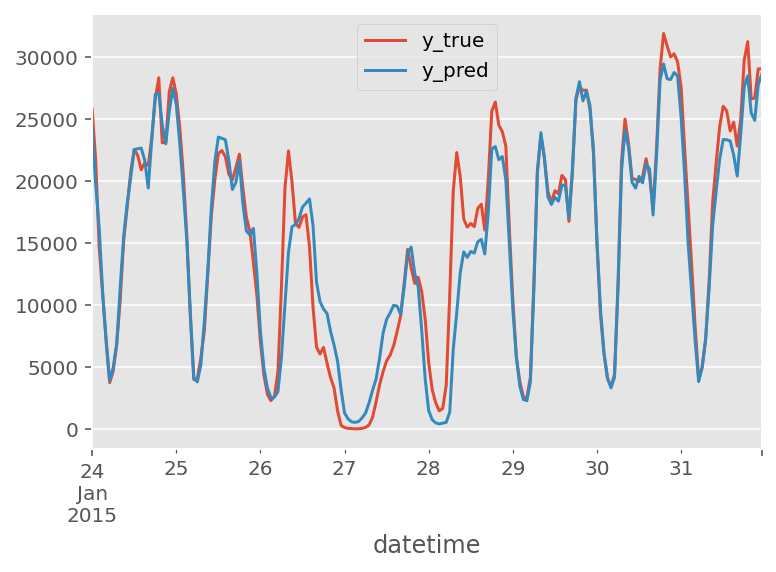

In [15]:
test_df.groupby('datetime').sum()[['y_true', 'y_pred']].plot();

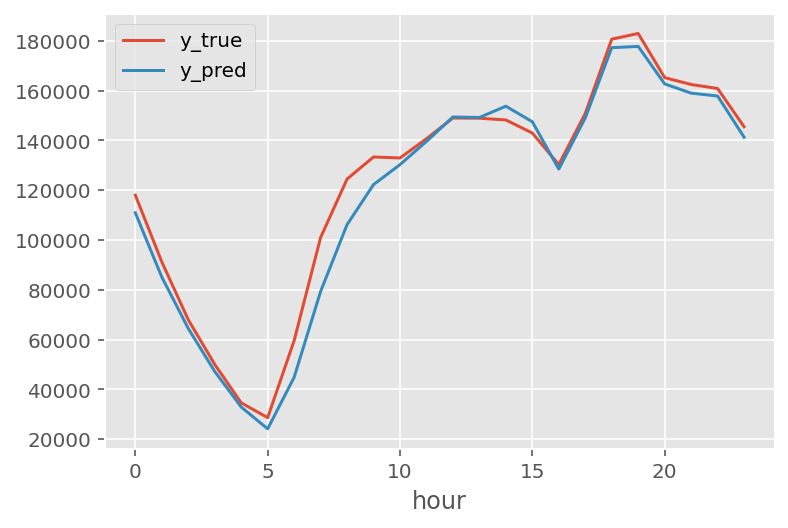

In [16]:
test_df[['hour','y_true', 'y_pred']].groupby('hour').sum()[['y_true', 'y_pred']].plot();

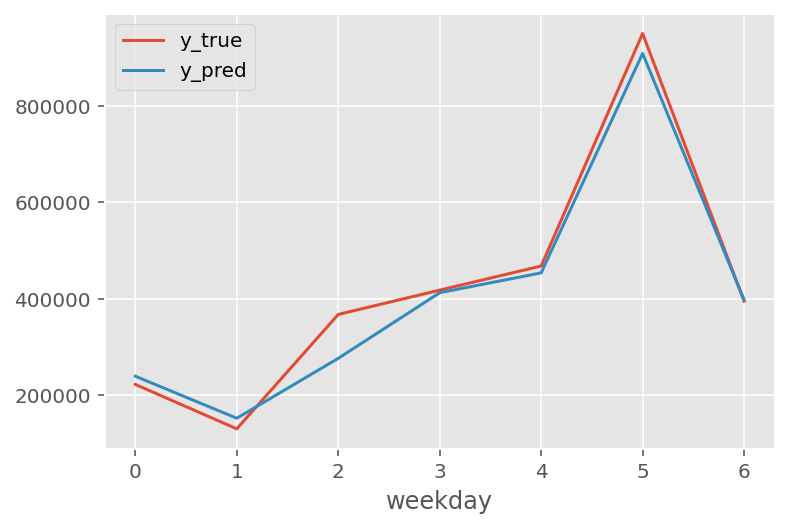

In [17]:
test_df[['weekday','y_true', 'y_pred']].groupby('weekday').sum()[['y_true', 'y_pred']].plot();

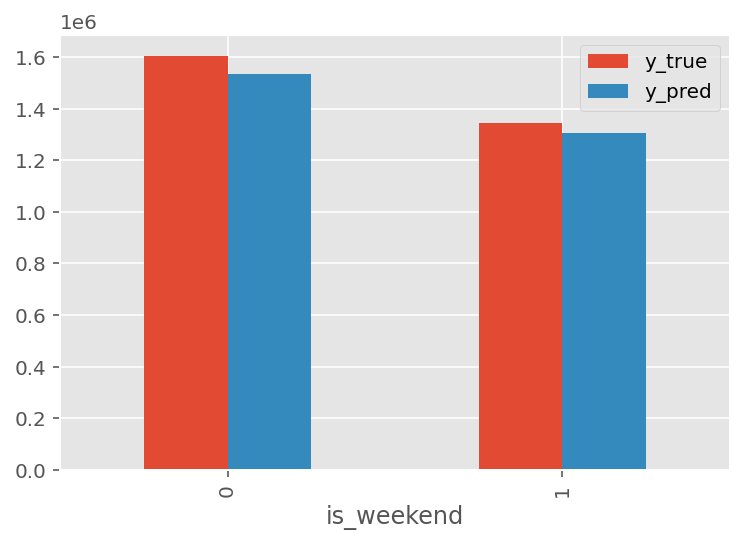

In [18]:
test_df[['is_weekend','y_true', 'y_pred']].groupby('is_weekend').sum()[['y_true', 'y_pred']].plot(kind='bar');